<center><h2>A/B Testing with Machine Learning</h2></center>

I was recently reading [Matt Dancho](https://www.linkedin.com/in/mattdancho/) of Business Science's A/B Testing with [Machine Learning - A Step-by-Step Tutorial](https://www.business-science.io/business/2019/03/11/ab-testing-machine-learning.html). I've always been intrigued by the concept of <b>A/B testing</b> and the potential influence it may have on businesses. The instruction is quite detailed, and Matt has thoroughly described each and every step. He has written down every choice he made while designing the answer.

Despite the fact that the course is written in <b>R</b>, I was able to scram through his code and comprehend the principles fast because to my experience of Data Science. I owe it to Matt to bring together all of the important parts of the Data Science field and use them to solve problems.

<b>I decided to try to duplicate the approach in Python and was successful. There are a few tiny variations in my implementation, but I believe they can be overlooked. Aside from cell annotations, I haven't gone through any of the processes because you should actually read the post I linked to.</b>

<center><h3>Table of Contents</h3></center>

<h3> A/B Testing with Machine Learning</h3>

* [Import Libraries & Files](#0)
* [Data Loading](#1)
* [Universal Basic Summary Function](#2)
* [Control Data Summary](#3)
* [Experiment Data Summary](#4)
* [Data Wrangling](#5)
* [Data Cleaning](#6)
    * [Data Reordering](#7)
* [Split Train and Test Data](#8)
    * [Converting String to numbers](#9)
    * [Train Data](#10)
    * [Test Data](#11)
* [Helper Function](#12)
    * [Function for printing the evaluation scores related to a regression problem](#12)
    * [Function for plotting the original values and values predicted by the model](#12)

<h3> Model 1: Linear Reression</h3>

* [Linear Regression Model](#13)
    * [Metrics Predictions](#14)
    * [Plotting the Prediction](#15)
    * [Model Summary](#16)
    * [p-Values](#17)
    
<h3> Model 2: Decision Tree</h3>

* [Decision Tree](#18)
    * [Metrics Predictions](#19)
    * [Plotting the Prediction](#20)
    * [Decission Tree Value Graph](#21)
    
<h3> Model 3:  XGBoost</h3>

* [XGBoost](#22)
    * [Setting Parameters](#23)
    * [Fitting and Train the Model](#24)
    * [Metrics Predictions](#25)
    * [Plotting the Prediction](#26)   

<a id="0"></a> <br> 
# Importing Libraries & Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import xgboost as xgb
import os
import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/Users/kushtrivedi/Downloads/A-B Testing/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/kushtrivedi/Downloads/A-B Testing/.DS_Store
/Users/kushtrivedi/Downloads/A-B Testing/A-B_Testing.ipynb
/Users/kushtrivedi/Downloads/A-B Testing/experiment_data.csv
/Users/kushtrivedi/Downloads/A-B Testing/control_data.csv
/Users/kushtrivedi/Downloads/A-B Testing/.ipynb_checkpoints/A-B_Testing-checkpoint.ipynb


<a id="1"></a> <br> 
# Data Loading

In [2]:
controlData = pd.read_csv('/Users/kushtrivedi/Downloads/A-B Testing/control_data.csv')
experimentData = pd.read_csv('/Users/kushtrivedi/Downloads/A-B Testing/experiment_data.csv')

<a id="2"></a> <br> 
# Universal Basic Summary Function

In [3]:
def basicSummary(dataFrameForSummary):
    print(f'Shape : {dataFrameForSummary.shape}')
    summary = pd.DataFrame(dataFrameForSummary.dtypes, columns=['Data Type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'Feature'})
    summary['Num of Nulls'] = dataFrameForSummary.isnull().sum().values
    summary['Num of Unique'] = dataFrameForSummary.nunique().values
    summary['First Value'] = dataFrameForSummary.loc[0].values
    summary['Second Value'] = dataFrameForSummary.loc[1].values
    summary['Third Value'] = dataFrameForSummary.loc[2].values
    summary['Fourth Value'] = dataFrameForSummary.loc[3].values
    summary['Fifth Value'] = dataFrameForSummary.loc[4].values
    return summary

<a id="3"></a> <br> 
# Contorl Data Summary

In [4]:
basicSummary(controlData)

Shape : (37, 5)


,Feature,Data Type,Num of Nulls,Num of Unique,First Value,Second Value,Third Value,Fourth Value,Fifth Value
0,Date,object,0,37,"Sat, Oct 11","Sun, Oct 12","Mon, Oct 13","Tue, Oct 14","Wed, Oct 15"
1,Pageviews,int64,0,37,7723,9102,10511,9871,10014
2,Clicks,int64,0,34,687,779,909,836,837
3,Enrollments,float64,14,20,134.0,147.0,167.0,156.0,163.0
4,Payments,float64,14,20,70.0,70.0,95.0,105.0,64.0


<a id="4"></a> <br> 
# Experiment Data Summary

In [5]:
basicSummary(experimentData)

Shape : (37, 5)


,Feature,Data Type,Num of Nulls,Num of Unique,First Value,Second Value,Third Value,Fourth Value,Fifth Value
0,Date,object,0,37,"Sat, Oct 11","Sun, Oct 12","Mon, Oct 13","Tue, Oct 14","Wed, Oct 15"
1,Pageviews,int64,0,37,7716,9288,10480,9867,9793
2,Clicks,int64,0,34,686,785,884,827,832
3,Enrollments,float64,14,20,105.0,116.0,145.0,138.0,140.0
4,Payments,float64,14,22,34.0,91.0,79.0,92.0,94.0


<a id="5"></a> <br> 
# Data Wrangling

In [6]:
# Combine with Experiment data
combineControlAndExperimentData = pd.concat([controlData, experimentData])
combineControlAndExperimentData.sample(10)

,Date,Pageviews,Clicks,Enrollments,Payments
14,"Sat, Oct 25",8669,669,127.0,81.0
27,"Fri, Nov 7",9424,781,NaN,NaN
29,"Sun, Nov 9",9656,825,NaN,NaN
10,"Tue, Oct 21",10660,867,196.0,105.0
16,"Mon, Oct 27",9655,771,213.0,119.0
23,"Mon, Nov 3",9437,788,NaN,NaN
25,"Wed, Nov 5",9633,808,NaN,NaN
33,"Thu, Nov 13",9717,814,NaN,NaN
13,"Fri, Oct 24",9434,673,220.0,122.0
8,"Sun, Oct 19",8434,697,120.0,77.0


<a id="6"></a> <br> 
# Data Cleaning

In [7]:
np.random.seed(7)

# Add row id
combineControlAndExperimentData['Row Id'] = combineControlAndExperimentData.index

# Create a Day of Week feature
combineControlAndExperimentData['DayOfWeek'] = combineControlAndExperimentData['Date'].str.slice(start=0, stop=3)

# Remove missing data
combineControlAndExperimentData.dropna(inplace=True)

# Add a binary column Experiment to denote
# if the data was part of the experiment or not (Random)
combineControlAndExperimentData['Experiment'] = np.random.randint(2, size=len(combineControlAndExperimentData))

# Remove missing data
combineControlAndExperimentData.dropna(inplace=True)

# Remove Date and Payments columns
del combineControlAndExperimentData['Date'], combineControlAndExperimentData['Payments']

# Shuffle the data
combineControlAndExperimentData = sklearn.utils.shuffle(combineControlAndExperimentData)

# Check the new data
combineControlAndExperimentData.head()

,Pageviews,Clicks,Enrollments,Row Id,DayOfWeek,Experiment
21,8460,681,156.0,21,Sat,0
3,9867,827,138.0,3,Tue,1
21,8448,695,142.0,21,Sat,0
13,9434,673,220.0,13,Fri,1
6,9008,748,146.0,6,Fri,1


<p id='7'><b><li>Data Reordering</li></b></p>

In [8]:
# Reorder the columns 
combineControlAndExperimentData = combineControlAndExperimentData[['Row Id', 'Experiment', 'Pageviews', 
                                                                   'Clicks', 'DayOfWeek', 'Enrollments']]
combineControlAndExperimentData.rename({'Pageviews': 'Page Views'}, axis=1, inplace=True)

<a id="8"></a> <br> 
# Split Train and Test Data

In [9]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    combineControlAndExperimentData.loc[:, combineControlAndExperimentData.columns != 'Enrollments'],
    combineControlAndExperimentData['Enrollments'], test_size=0.2)

<p id='9'><b><li>Converting String to numbers</li></b></p>

In [10]:
# Converting strings to numbers
labelEncoder = LabelEncoder()
X_train['DayOfWeek'] = labelEncoder.fit_transform(X_train['DayOfWeek'])
X_test['DayOfWeek'] = labelEncoder.transform(X_test['DayOfWeek'])

<p id='10'><b><li>Train Data</li></b></p>

In [11]:
X_train.head()

,Row Id,Experiment,Page Views,Clicks,DayOfWeek
16,16,0,9535,759,1
10,10,1,10551,864,5
2,2,0,10480,884,1
3,3,1,9867,827,5
16,16,0,9655,771,1


<p id='11'><b><li>Test Data</li></b></p>

In [12]:
X_test.head()

,Row Id,Experiment,Page Views,Clicks,DayOfWeek
12,12,0,8324,665,4
18,18,1,9262,727,6
1,1,0,9288,785,3
1,1,0,9102,779,3
19,19,0,9345,734,4


<a id="12"></a> <br> 
# Helper functions

* Function for printing the evaluation scores related to a regression problem
* Function for plotting the original values and values predicted by the model

In [13]:
# Function for printing the evaluation scores related to a regression problem
def calculateMetrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))
    
# Function for plotting the original values and values predicted by the model    
plt.style.use('ggplot')
%matplotlib inline
def plotPredcitions(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(15,10))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue',s=80)
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red',s=80)
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('Oberservations',fontweight="bold")
    plt.ylabel('Enrollments',fontweight="bold")
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

<a id="13"></a> <br> 
# Model 1: Linear Regression

In [14]:
# Fitting the model
X_train_refined = X_train.drop(columns=['Row Id'], axis=1)
linearRegression = sm.OLS(y_train, X_train_refined)
linearRegression = linearRegression.fit()

# Predicting the model
X_test_refined = X_test.drop(columns=['Row Id'], axis=1)
y_preds = linearRegression.predict(X_test_refined)

<p id= '14'><b><li>Metrics Predictions</li></b></p>

In [15]:
calculateMetrics(y_test, y_preds)

RMSE Score: 23.988871314039855
R2_Squared: 0.05095001827039325
MAE Score: 19.586061838775088


<p id= '15'><b><li>Plotting the Prediction</li></b></p>

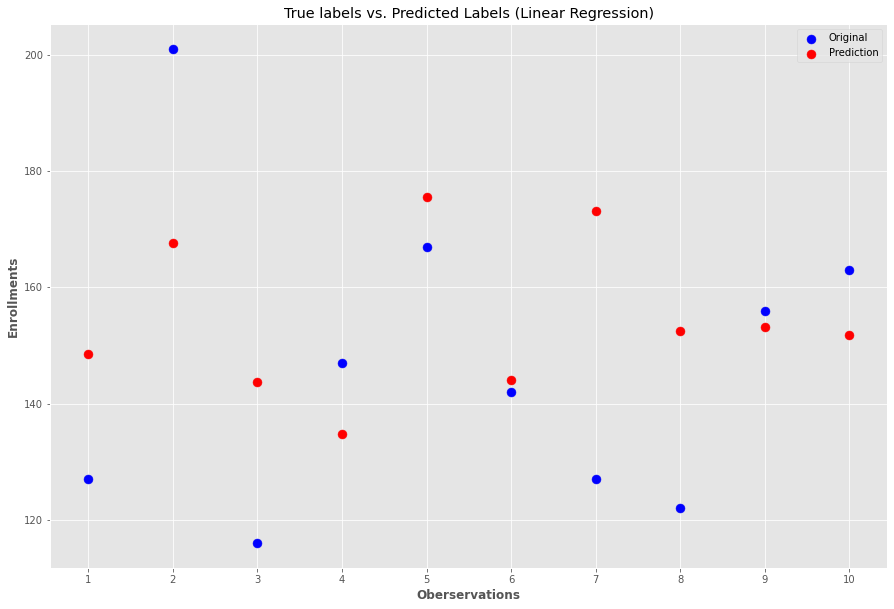

In [16]:
plotPredcitions(y_test, y_preds, 'Linear Regression')

<p id= '16'><b><li>Model Summary</li></b></p>

In [17]:
print(linearRegression.summary())

                                 OLS Regression Results                                
Dep. Variable:            Enrollments   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              400.1
Date:                Thu, 06 Jan 2022   Prob (F-statistic):                    7.92e-27
Time:                        23:34:45   Log-Likelihood:                         -163.65
No. Observations:                  36   AIC:                                      335.3
Df Residuals:                      32   BIC:                                      341.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<p id= '17'><b><li>p-Values</li></b></p>

In [18]:
pd.DataFrame(linearRegression.pvalues).reset_index()\
.rename(columns={'index':'Terms', 0:'p_value'}).sort_values('p_value')

,Terms,p_value
1,Page Views,1.974764e-07
2,Clicks,3.804647e-05
3,DayOfWeek,2.299762e-01
0,Experiment,8.634578e-01


<a id="18"></a> <br> 
# Model 2: Decision Tree

In [19]:
# Fitting the model
decissionTreeRegressor = DecisionTreeRegressor(max_depth=5, min_samples_leaf =4, random_state=7)
decissionTreeRegressor.fit(X_train_refined, y_train)
# Predicting the model
y_preds = decissionTreeRegressor.predict(X_test_refined)

<p id= '19'><b><li>Metrices Predictions</li></b></p>

In [20]:
calculateMetrics(y_test, y_preds)

RMSE Score: 26.8540034259326
R2_Squared: -0.1892893660531696
MAE Score: 21.78333333333333


<p id= '20'><b><li>Plotting the Predictions</li></b></p>

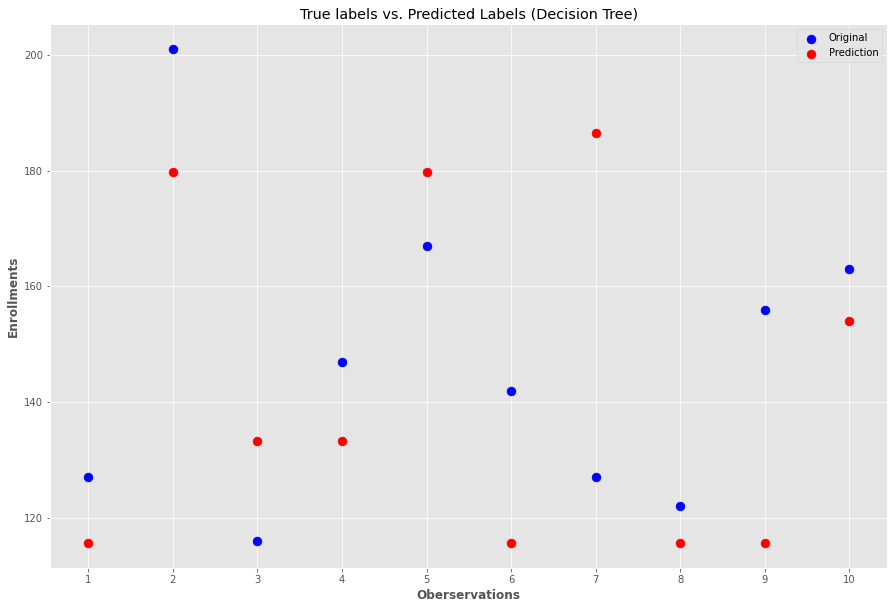

In [21]:
plotPredcitions(y_test, y_preds, 'Decision Tree')

<p id= '21'><b><li>Decission Tree Value Graph</li></b></p>

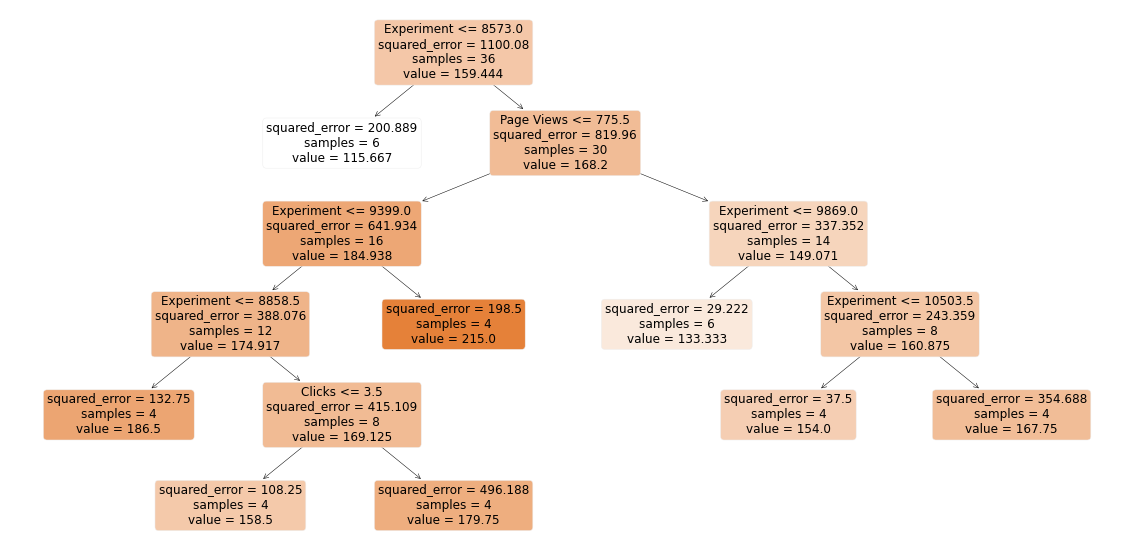

In [22]:
plt.figure(figsize=(20, 10))
tree.plot_tree(decissionTreeRegressor, 
               filled=True, rounded=True, 
               feature_names = X_train.columns,
               fontsize=12)
plt.show()

<a id="22"></a> <br> 
# Model 3: XGBoost

In [23]:
DM_train = xgb.DMatrix(data=X_train_refined,label=y_train)
DM_test = xgb.DMatrix(data=X_test_refined,label=y_test)

<p id ='23'><b><li>Setting Parameters</li></b></p>

In [24]:
xgb.set_config(verbosity=0)
parameters = {
    'max_depth': 6,
    'objective': 'reg:squarederror',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}

<p id ='24'><b><li>Fitting and Train the Model</li></b></p>

In [25]:
xg_reg = xgb.train(params = parameters, dtrain=DM_train, num_boost_round=8)
y_preds = xg_reg.predict(DM_test)

<p id ='25'><b><li>Metrics Predictions</li></b></p>

In [26]:
calculateMetrics(y_test, y_preds)

RMSE Score: 20.298967362913974
R2_Squared: 0.3204563691525716
MAE Score: 18.10905303955078


<p id ='26'><b><li>Plotting the Predictions</li></b></p>

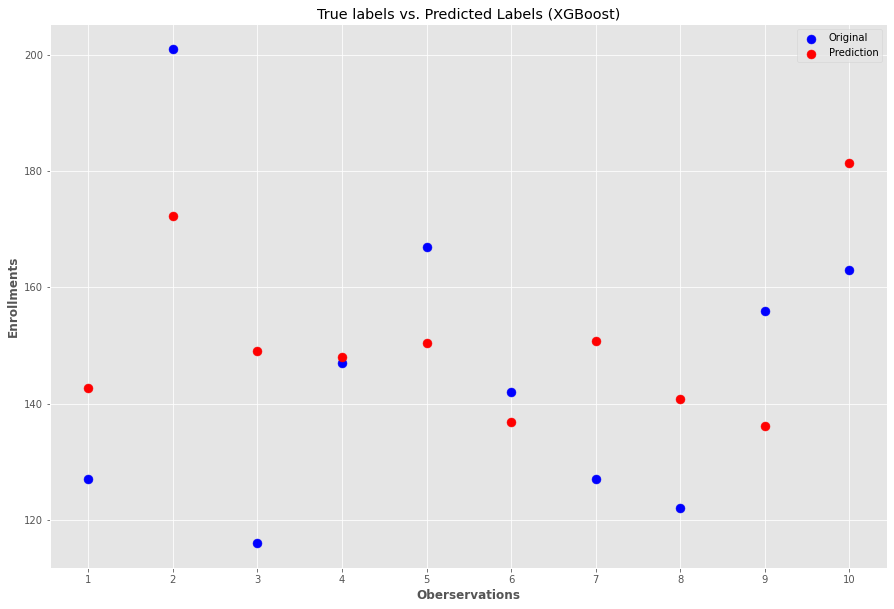

In [27]:
plotPredcitions(y_test, y_preds, 'XGBoost')

<center><h1> XGBoost wins as it's RMSE Score is low compare to other two models.</h1></center>